In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator


## For analytical calculation

In [2]:
def G(xx, x0, w=0.8):
    """Gaussian potential"""
    d_xx=xx-x0
    sqr_dxx=d_xx*d_xx
    sqr_ww=w*w
    return A*np.exp(-0.5*sqr_dxx/sqr_ww)

def u4(xx, yy, w_x, w_y=1.2):
    """diamond 4-state model potential in 2-dim"""
    return 0.0001*(xx**6+yy**6)-G(xx, 2.0, w_x)*G(yy, 2.0, w_y)-G(xx, -2.0, w_x)*G(yy, 2.0, w_y)\
                               -G(xx, 2.0, w_x)*G(yy, -2.0, w_y)-G(xx, -2.0, w_x)*G(yy, -2.0, w_y)

def mean_f4_x(xx, w_x, beta):
    """mean force in x direction."""
    min_y, max_y = -100.0, 100.0
    Nslice = 10000
    yy = np.linspace(min_y, max_y, Nslice)
    dy = (max_y - min_y)/Nslice
    fy = np.exp(-beta*u4(xx,yy,w_x))
    I = np.sum(fy*dy)    
    return (-1/beta)*np.log(I)

def mean_f4_y(yy, w_x, beta):
    """mean force in x direction."""
    min_x, max_x = -100.0, 100.0
    Nslice = 10000
    xx = np.linspace(min_x, max_x, Nslice)
    dx = (max_x - min_x)/Nslice
    fx = np.exp(-beta*u4(xx,yy,w_x))
    I = np.sum(fx*dx)    
    return (-1/beta)*np.log(I)

def mean_f4_s(ss, th, w_x, beta):
    """project along RC with tilt angle th."""
    min_x, max_x = -100.0, 100.0
    Nslice = 20000
    xx = np.linspace(min_x, max_x, Nslice)
    dx = (max_x - min_x)/Nslice
    
    coeff_x, coeff_y = np.cos(th), np.sin(th)
    if abs(coeff_y)>=abs(coeff_x):
        yy=ss/coeff_y-coeff_x*xx/coeff_y
        fx = np.exp(-beta*u4(xx,yy,w_x))
        I = np.sum(fx*dx)
    else:
        dy = dx
        yy = xx
        xx = ss/coeff_x-coeff_y*yy/coeff_x
        fy = np.exp(-beta*u4(xx,yy,w_x))
        I = np.sum(fy*dy)
    
    return (-1/beta)*np.log(I)


## For biased reweighting

In [3]:
def Vbias(s, hbias, sbias, wbias):
    """
    sum of biases added at position s.
    """
    Vbias = np.sum(hbias*np.exp(-0.5*(s-sbias)**2/wbias**2))
    return Vbias

def exp_beta_Vbias(s, nline, hbias, sbias, wbias, beta):
    """
    exp(beta*Vbias)
    Number of hbias and sbias should less than or equal to nline.
    """
    if nline<len(hbias) or nline<len(sbias):
        raise TypeError
    
    Vbias = np.sum(hbias*np.exp(-0.5*(s-sbias)**2/wbias**2))
    return np.exp(beta*Vbias)

def exp_beta_c(nline, hbias, sbias, wbias, beta, delta_beta):
    """
    exp(beta*c[nline]) # nline is t in unit of lines.
    Number of hbias and sbias should less than or equal to nline.
    """
    # if the following statement is not true, the causality breaks.
    if nline<len(hbias) or nline<len(sbias):
        raise ValueError
    # nline=0 is the initial configuration. Without this line, the following sb_max/sb_min break.
    if nline==0: 
        return 1
    
    T, dT = (1/beta, 1/delta_beta)
    exp_num, exp_den = ((T+dT)/dT, T/dT)
    
    ds=0.5 # integration interval
    sb_max=np.max(sbias)+3*ds
    sb_min=np.min(sbias)-3*ds

    num=np.sum([exp_beta_Vbias(ss, nline, hbias, sbias, wbias, beta)**exp_num for ss in np.arange(sb_min, sb_max, ds)])
    den=np.sum([exp_beta_Vbias(ss, nline, hbias, sbias, wbias, beta)**exp_den for ss in np.arange(sb_min, sb_max, ds)])
    
    return num/den


# Analytic Free Energy

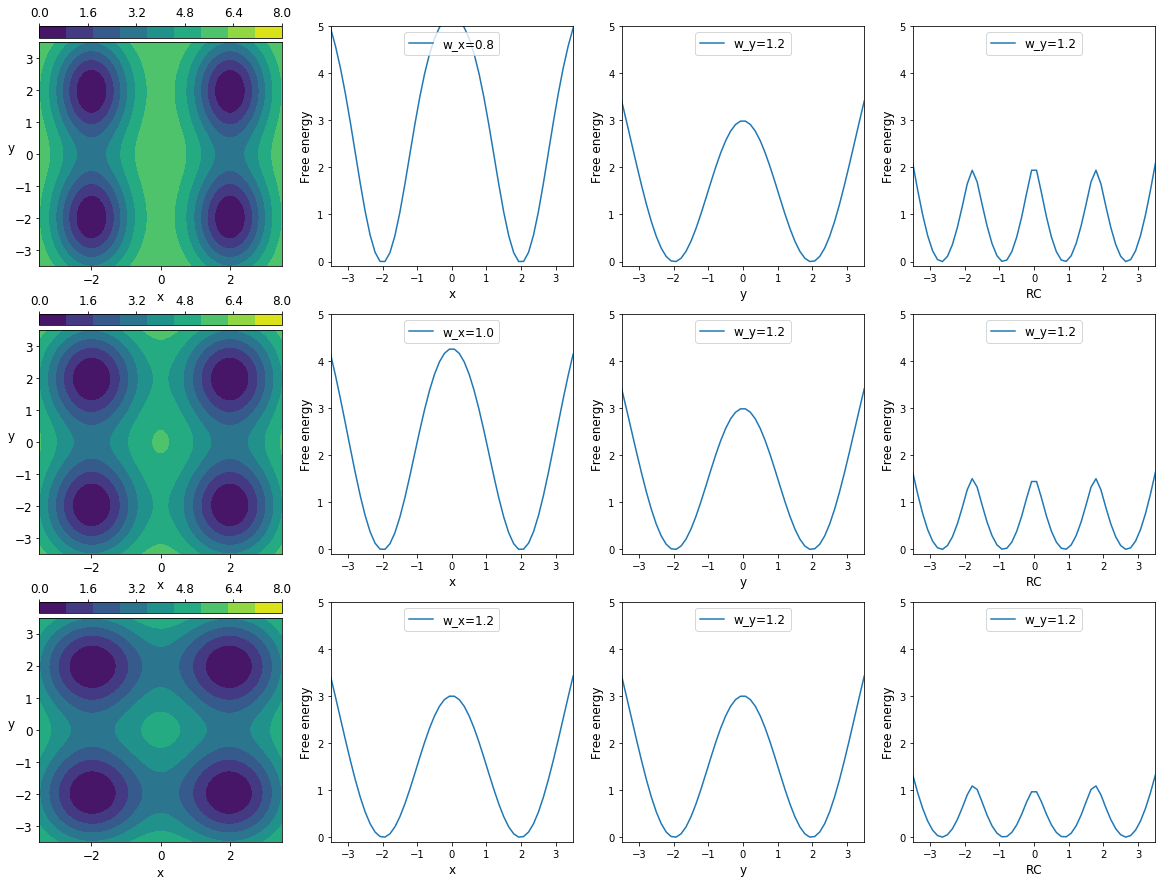

In [4]:
# Parameters:
beta=2.5
A=2.5
w_x=[0.8, 1.0, 1.2]
w_y=1.2
th=0.15*np.pi # RC = cos(0.15*pi), sin(0.15*pi)

# data:
x4=np.linspace(-3.5, 3.5)
y4=np.linspace(-3.5, 3.5)
s4=np.linspace(-3.5, 3.5)
xv4, yv4 = np.meshgrid(x4, y4)
levels=np.linspace(0.0, 8.0, 10)


fig, ax=plt.subplots(figsize=(20,15), nrows=3, ncols=4)

for i in range(3):
    # data:
    fE4 = u4(xv4, yv4, w_x[i])
    pmf4_x=[mean_f4_x(xi, w_x[i], beta) for xi in x4]
    pmf4_y=[mean_f4_y(yi, w_x[i], beta) for yi in y4]
    pmf4_s=[mean_f4_s(si, th, w_x[i], beta) for si in s4]
    
    # Plottings:
    ctrp = ax[i,0].contourf(x4, y4, fE4-np.min(fE4), levels=levels)

    divider = make_axes_locatable(ax[i,0])
    cax = divider.append_axes('top', size='5%', pad='2%')
    ticks=np.round(np.linspace(0.0, 8.0 , 6), 1)
    cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
    cax.xaxis.set_ticks_position('top')
    cbr.ax.tick_params(labelsize=12) 

    ax[i,0].tick_params(axis='both', which='major', labelsize=12)
    ax[i,0].set_xlabel('x', size=12)
    ax[i,0].set_ylabel('y', size=12).set_rotation(0)
    ax[i,0].set_xlim(-3.5,3.5)
    ax[i,0].set_ylim(-3.5,3.5)

    ax[i,1].plot(x4, pmf4_x-np.min(pmf4_x), label='w_x={}'.format(w_x[i]))
    ax[i,1].set_xlabel('x', size=12)
    ax[i,1].set_ylabel('Free energy', size=12)
    ax[i,1].legend(loc='upper center', fontsize=12)
    ax[i,1].set_xlim(-3.5,3.5)
    ax[i,1].set_ylim(-0.1,5.0)

    ax[i,2].plot(y4, pmf4_y-np.min(pmf4_y), label='w_y={}'.format(w_y))
    ax[i,2].set_xlabel('y', size=12)
    ax[i,2].set_ylabel('Free energy', size=12)
    ax[i,2].legend(loc='upper center', fontsize=12)
    ax[i,2].set_xlim(-3.5,3.5)
    ax[i,2].set_ylim(-0.1,5.0)
    
    ax[i,3].plot(y4, pmf4_s-np.min(pmf4_s), label='w_y={}'.format(w_y))
    ax[i,3].set_xlabel('RC', size=12)
    ax[i,3].set_ylabel('Free energy', size=12)
    ax[i,3].legend(loc='upper center', fontsize=12)
    ax[i,3].set_xlim(-3.5,3.5)
    ax[i,3].set_ylim(-0.1,5.0)

plt.show()


# Computation

## Unbiased result:

In [5]:
# Load data:
filename='./DATA/unbiased/beta2.5/xvyw1beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w1.0B1.0a1.0_h0.01.txt'
x, y = np.loadtxt(filename, unpack=True, usecols=(0,1), skiprows=1)


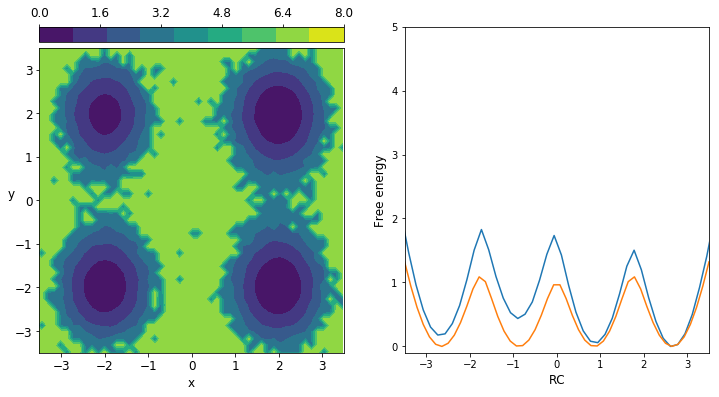

In [6]:
# parameters:
beta=2.5
w_x=1.2
levels=np.linspace(0, 8.0, 10)
th=0.15*np.pi
coeff_x, coeff_y = np.cos(th), np.sin(th)

# data:
hist2d=np.histogram2d(x, y, bins=50)
prob2d=hist2d[0].T/np.sum(hist2d[0])
freeE2d=(-1/beta)*np.log(prob2d+1e-9)
x2d=0.5*(hist2d[1][1:]+hist2d[1][:-1])
y2d=0.5*(hist2d[2][1:]+hist2d[2][:-1])

hist1d=np.histogram(coeff_x*x+coeff_y*y, bins=50)
prob1d=hist1d[0].T/np.sum(hist1d[0])
freeE1d=(-1/beta)*np.log(prob1d+1e-9)
x1d=0.5*(hist1d[1][1:]+hist1d[1][:-1])

pmf4_s=[mean_f4_s(si, th, w_x, beta) for si in s4]

# Plottings:
fig, ax=plt.subplots(figsize=(12,6), nrows=1, ncols=2)
ax=ax.flatten()

ctrp = ax[0].contourf(x2d, y2d, freeE2d-np.min(freeE2d), levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 8.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('x', size=12)
ax[0].set_ylabel('y', size=12).set_rotation(0)
ax[0].set_xlim(-3.5, 3.5)
ax[0].set_ylim(-3.5, 3.5)

ax[1].plot(x1d, freeE1d-np.min(freeE1d))
ax[1].plot(s4, pmf4_s-np.min(pmf4_s))
ax[1].set_xlabel('RC', size=12)
ax[1].set_ylabel('Free energy', size=12)
ax[1].set_xlim(-3.5, 3.5)
ax[1].set_ylim(-0.1, 5.0)

plt.show()

## Biased result:

The units in the output file are "lines". <br>
The output rate is denoted as "Rout". <br>
Each line corresponding to "Rout" steps in simulation.

In [7]:
filename='./DATA/h0_4_w0_2_db0_01_stride200_cx0_891_cy0_454/xvyw1beta2.5gammax1.0gammay1.0epsln1.0sgma1.0A2.5x01.122w1.0B1.0a1.0_h0.01.txt'
x, y, hbias, xbias, ybias = np.loadtxt(filename, unpack=True, usecols=(0,1,6,7,8), skiprows=1)


In [8]:
# parameters:
## integration
nline = 56 # (unit: lines), t=166*Rout=16600 steps
Rout = 100 # (unit: steps/lines)
## MD
beta=2.5
w_x=1.0
## metadynamics
coeff_x, coeff_y = (0.891, 0.454)
stride=200
stride = stride//Rout # (unit: lines), stride = 1000 steps
wbias=0.2
delta_beta=0.01

# data:
s=coeff_x*x+coeff_y*y
sbias=coeff_x*xbias+coeff_y*ybias

# Create array of correction with zeros:
weights=np.zeros(s.shape[0])

for i, si in enumerate(s):
    sbias_t=sbias[:i:stride]
    hbias_t=hbias[:i:stride]
    weights[i]=exp_beta_Vbias(si, i, hbias_t, sbias_t, wbias, beta)/exp_beta_c(i, hbias_t, sbias_t, wbias, beta, delta_beta)


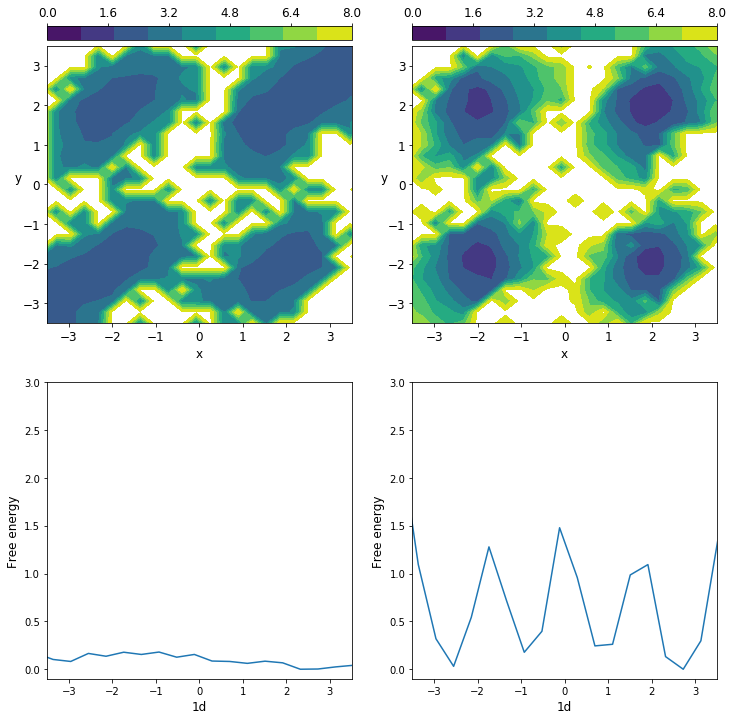

In [9]:
# Parameters:
beta=2.5
levels=np.linspace(0, 8.0, 10)

# data:
biased_hist2d=np.histogram2d(x, y, bins=50)
biased_prob2d=biased_hist2d[0].T/np.sum(biased_hist2d[0])
biased_freeE2d=(-1/beta)*np.log(biased_prob2d+1e-9)
biased_x2d=0.5*(biased_hist2d[1][1:]+biased_hist2d[1][:-1])
biased_y2d=0.5*(biased_hist2d[2][1:]+biased_hist2d[2][:-1])

rw_hist2d=np.histogram2d(x, y, weights=weights, bins=50)
rw_prob2d=rw_hist2d[0].T/np.sum(rw_hist2d[0])
rw_freeE2d=(-1/beta)*np.log(rw_prob2d+1e-9)
rw_x2d=0.5*(rw_hist2d[1][1:]+rw_hist2d[1][:-1])
rw_y2d=0.5*(rw_hist2d[2][1:]+rw_hist2d[2][:-1])

biased_hist1d=np.histogram(coeff_x*x+coeff_y*y, bins=50)
biased_prob1d=biased_hist1d[0].T/np.sum(biased_hist1d[0])
biased_freeE1d=(-1/beta)*np.log(biased_prob1d+1e-9)
biased_x1d=0.5*(biased_hist1d[1][1:]+biased_hist1d[1][:-1])

rw_hist1d=np.histogram(coeff_x*x+coeff_y*y, weights=weights, bins=50)
rw_prob1d=rw_hist1d[0].T/np.sum(rw_hist1d[0])
rw_freeE1d=(-1/beta)*np.log(rw_prob1d+1e-9)
rw_x1d=0.5*(rw_hist1d[1][1:]+rw_hist1d[1][:-1])

# Plottings:
fig, ax=plt.subplots(figsize=(12,12), nrows=2, ncols=2)
ax=ax.flatten()

ctrp = ax[0].contourf(biased_x2d, biased_y2d, biased_freeE2d, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 8.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ctrp = ax[1].contourf(rw_x2d, rw_y2d, rw_freeE2d, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0.0, 8.0 , 6), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=12)

ax[2].plot(biased_x1d, biased_freeE1d-np.min(biased_freeE1d))
ax[3].plot(rw_x1d, rw_freeE1d-np.min(rw_freeE1d))

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel('x', size=12)
ax[0].set_ylabel('y', size=12).set_rotation(0)
ax[0].set_xlim(-3.5, 3.5)
ax[0].set_ylim(-3.5, 3.5)

ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('x', size=12)
ax[1].set_ylabel('y', size=12).set_rotation(0)
ax[1].set_xlim(-3.5, 3.5)
ax[1].set_ylim(-3.5, 3.5)

ax[2].set_xlabel('1d', size=12)
ax[2].set_ylabel('Free energy', size=12)
ax[2].set_xlim(-3.5, 3.5)
ax[2].set_ylim(-0.1,3.0)

ax[3].set_xlabel('1d', size=12)
ax[3].set_ylabel('Free energy', size=12)
ax[3].set_xlim(-3.5, 3.5)
ax[3].set_ylim(-0.1,3.0)

plt.show()


In [ ]:
# parameters:
T, dT = 1/beta, 1/delta_beta
prefactor=-(T+dT)/dT

# data (The bias is added every stride):
rw_fE=prefactor*np.array([Vbias(si, hbias[::stride], sbias[::stride], wbias) for si in s4])
pmf4_s=[mean_f4_s(si, th, w_x, beta) for si in s4]

# Plottings:
fig, ax=plt.subplots(figsize=(6,6), nrows=1, ncols=1)

ax.plot(s4, pmf4_s-np.min(pmf4_s), label='analytical')
ax.plot(x4, rw_fE-np.min(rw_fE), label='collect Vbias directly')
ax.plot(rw_x1d, rw_freeE1d-np.min(rw_freeE1d), label='reweighted by c(t)')

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('RC', size=12)
ax.set_ylabel('Free energy', size=12)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-0.1, 5.0)

ax.legend(loc='upper center', fontsize=12)

plt.show()
